<a href="https://colab.research.google.com/github/kabilank6/Twitter-Sentiment-Analysis/blob/main/Twitter_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We first need to ingest the csv file so we can take its information for further processing later on. From inspection, we see that the data is unstructured (that is, not laid out in things like columns - each relevant line/row just represents what is said in a tweet). 

In my view, the best way to take the data in is then to open the csv, then read the csv (like a text file - fortunately Python has a library called "csv" for this purpose), and to append any relevant rows (that is, that has a tweet) to a list which I will call "tweet_list". From this, we have everything we need in one place (the list), and we can do whatever analysis we desire after.

In [ ]:
import csv

tweet_list = []

# Can replace "support_tweets.csv" with desired csv filename. The assumption here
# is that the only row that doesn't contain a tweet other than an empty
# row is that which contains the string "tweet_text", like in the csv provided.


with open("support_tweets_testing.csv") as csv_file:
    csv_reader = csv.reader(csv_file)
    line_count = 0
    for row in csv_reader:
      item = "".join(row)
      if item != "" and item != "tweet_text":
        tweet_list.append(item)
print(tweet_list)
print(len(tweet_list))

["@122266 Thanks Lisa, I'll make sure your concerns are passed on. If you let me have your Nectar card number via the link, I'll sort you out...1/2 https://t.co/MdMtnTlX6H", "@122395 Hi Rebecca, we can appreciate what's happened has made you feel nervous about travelling. Speak to our crew on Saturday 1/2 ^Sophie", "@122396 We appreciate it's frustrating to wait so long, Gerry. Unfortunately due to high volumes off the back of the disruption we've faced this 1/2", '@122444 Hi Ed, Delay Repay is widely used in the industry and is actually more beneficial for passengers as it allows you to claim if you are 1/3', '@122444 delayed by 30 minutes or more. The previous system required the service for the whole network to drop below a certain level before 2/3', "@122518 Hi Kenny, we'll certainly be able to help you with this. Let us know via DM the contact details you would like to update, 1/2 ^Sophie", "@122521 Hi Alex! I've spoke to Immigration, and there's no age limit for entering the UK. 

As outlined in Task One, we want to extract the sentiment of each tweet. Before going into this however, it is worth breaking down what we can expect from each sentence, so we understand how to deal with each sentence. To achieve this, we can look at examples from the csv file we are given.

'@AppleSupport causing the reply to be disregarded and the tapped notification under the keyboard is opened😡😡😡' is an example.

We can see from this (and cross inspection with other examples) that there are three specific common parts to each tweet. The @ part (for the Twitter handle of someone being mentioned), the message (in this case it's in one sentence, however in others the tweet's message could be covered through at least two sentences). Lastly, in this and several other cases, there often is an emoji included somewhere (in the sentence mentioned above, we can see it is angry). In some tweets, we can see initials of a company representative replying to a query (for example, "RR" in "@105835 Your business means a lot to us. Please DM your name, zip code and additional details about your concern. ^RR https://t.co/znUu1VJn9r"). Due to the limited time of this task, I will assume that this will be treated as neutral (as we intuitively would want to treat it) by any sentiment analysis library we use.

With this in mind, perhaps the only part of the tweet that might be worth giving special treatment to is the emoji. From doing some research, I found [this Stack Overflow post](https://stackoverflow.com/questions/57744725/how-to-convert-emojis-emoticons-to-their-meanings-in-python) that suggested a good way to objectively deal with the emoji is to convert it to a relevant word that describes its sentiment well (our choice of model will handle the rest after with the rest of the text). However, it seems unweldy to copy a lot of code for a few specific emojis, and it would be nice if there was a library that did this for us. Fortunately, [VADER Sentiment Analysis](https://pypi.org/project/vader-sentiment/) seems to be good with dealing with UTF-8 encoded emojis, and social media style sentiment analysis, so it is worth looking into it.

In [ ]:
!pip install vaderSentiment

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
for sentence in tweet_list:
    vs = analyzer.polarity_scores(sentence)
    print("{:-<65} {}".format(sentence, str(vs)))

@122266 Thanks Lisa, I'll make sure your concerns are passed on. If you let me have your Nectar card number via the link, I'll sort you out...1/2 https://t.co/MdMtnTlX6H {'neg': 0.0, 'neu': 0.794, 'pos': 0.206, 'compound': 0.6705}
@122395 Hi Rebecca, we can appreciate what's happened has made you feel nervous about travelling. Speak to our crew on Saturday 1/2 ^Sophie {'neg': 0.081, 'neu': 0.814, 'pos': 0.105, 'compound': 0.1531}
@122396 We appreciate it's frustrating to wait so long, Gerry. Unfortunately due to high volumes off the back of the disruption we've faced this 1/2 {'neg': 0.254, 'neu': 0.661, 'pos': 0.085, 'compound': -0.6557}
@122444 Hi Ed, Delay Repay is widely used in the industry and is actually more beneficial for passengers as it allows you to claim if you are 1/3 {'neg': 0.073, 'neu': 0.826, 'pos': 0.101, 'compound': 0.2247}
@122444 delayed by 30 minutes or more. The previous system required the service for the whole network to drop below a certain level before 2/3 {

From reading the VaderSentiment documentation, for our purposes (classifying sentiment for each whole tweet), we can assess each tweet's compound score (the 'compound' field in the SentimentIntensityAnalyzer). Due to time constraints, I will use this as a proxy for our sentiment classification.

Based off the documentation, a compound score of at least 0.05 is positive, less than this but over -0.05 is neutral, and less than or equal to -0.05 is negative.

With this in mind, I will classify each tweet as such, and subsequently create a pie chart that visualises the proportion of tweets that are considered as positive, neutral and negative.

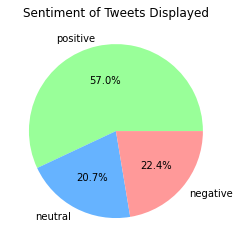

In [ ]:
sentiment_dictionary = {"positive": 0, "neutral": 0, "negative": 0}

for sentence in tweet_list:
    vs = analyzer.polarity_scores(sentence)
    compound = vs["compound"]
    if compound >= 0.05:
      sentiment_dictionary["positive"] += 1
    elif compound > -0.05:
      sentiment_dictionary["neutral"] += 1
    else:
      sentiment_dictionary["negative"] += 1

import matplotlib.pyplot as plt
import numpy as np

plot_labels = []
quantities = []
for item in sentiment_dictionary:
  plot_labels.append(item)
  quantity = sentiment_dictionary[item]
  quantities.append(quantity)
quantities = np.array(quantities)
colours = ["#99ff99","#66b3ff", "#ff9999"]
plt.pie(quantities, labels = plot_labels, colors=colours, autopct="%1.1f%%")
plt.title('Sentiment of Tweets Displayed')
plt.show() 

It seems that a slight majority of all our tweets (in the initial dataset at least) are considered as positive by the model. This is interesting, and perhaps we want to investigate how trustworthy these results are. In my view, this would be achieved by inspecting results that are classified as 'positive' individually.

In [ ]:
for sentence in tweet_list:
    vs = analyzer.polarity_scores(sentence)
    compound = vs["compound"]
    if compound >= 0.05:
      print("\'{}\' has a compound of {}!".format(sentence, compound))

'@122266 Thanks Lisa, I'll make sure your concerns are passed on. If you let me have your Nectar card number via the link, I'll sort you out...1/2 https://t.co/MdMtnTlX6H' has a compound of 0.6705!
'@122395 Hi Rebecca, we can appreciate what's happened has made you feel nervous about travelling. Speak to our crew on Saturday 1/2 ^Sophie' has a compound of 0.1531!
'@122444 Hi Ed, Delay Repay is widely used in the industry and is actually more beneficial for passengers as it allows you to claim if you are 1/3' has a compound of 0.2247!
'@122518 Hi Kenny, we'll certainly be able to help you with this. Let us know via DM the contact details you would like to update, 1/2 ^Sophie' has a compound of 0.765!
'@122547 hi Phoebe, I'll make sure your concerns are shared with our buyers. If you let me have your Nectar card number via the link, I'll...1/2 https://t.co/MdMtnTlX6H' has a compound of 0.6124!
'@122559 Sorry to hear that Spencer, we are committed to improving the Wi-Fi on our trains http

From my (admittedly subjective) observation, it seems that most of these 'positive' tweets are replies to queries on behalf of a company (perhaps VADER picked up optimistic tones from these via words used politely in this context like 'like', 'help' and 'happy' that tend to be interpreted positively, and this increased their compound scores?). There also tend to be a lot of inclusive pronouns/words like 'we', 'together' and 'our' that may add to this nuance that is interpreted positively by VADER. I also note that positive emojis like ":-)", "🤗" and "😊" (to name a few) come up in these tweets, which likely drives the compound score up as we are told that VADER takes them into account. Otherwise, there are some clear positive tweets here too - such as happy customer reviews. For example, "@AppleSupport Super help - problem solved 😀 once again in love with Apple" and "@AppleSupport Okey. Thank you! 🤗" seem quite positive to me. 

There also are a few exceptions (where would the fun be if there weren't?). For example, "Okay @76099 I used my fucking phone for 2 minutes and it drains it down 8 fucking percent" does not seem positive at all to me (in fact, it clearly seems negative). Perhaps its compound score is relatively high due to the sexual connotations of the "f word" (which can be interpreted in a positive or happy way). Also, "@Uber_Support @115879 wouldn't do this to me 😔" seems like a disappointed tweet, so if this is the case it shouldn't be considered positive. Perhaps in this case, the algorithm is interpreting the sentence as the tweeter speaking positively about @115879, rather than negatively about @Uber_Support. However, from inspection, these seem to be some relatively rare extreme exceptions, but overall most of the positive classifications seem reasonable to me (although I may not fully agree that each of them should be considered positive overall).

While I wouldn't consider seeing if we can adjust the results due to limited time, I think it is worth at least considering that there is an argument that a lot of these more 'nuanced' (that is, using less strong positive words) and less emoji-filled tweets are better placed to be classified as 'neutral' rather than 'positive'. Outside of retraining or changing our model, perhaps we could consider changing the thresholds to deal with these questionable results to fine-tune the model to align with our expectations.

Otherwise, let's consider the other tasks.

To see how many times a specific inputted (lower case - assuming this is the format) word or handle has been seen in all tweets, we can create a specific function for this purpose. The way I would do this is to make a function that inspects each tweet (via the tweets list), and find if that word/handle appears in each tweet (once is sufficient for each tweet - I think worrying about repetition can bias the integrity of the function's results), and accumulate to a counter it returns at the end if so.

In [ ]:
def word_commonality(word):
  word = word.lower()
  count = 0
  for tweet in tweet_list:
    split_tweet = tweet.split()
    for item in split_tweet:
      item = item.lower()
      if item == word:
        count += 1
        break
  return count

Let's run some examples (on our initial data). I will try "thanks" and "@applesupport".

In [ ]:
print("The word commonality of \'thanks\' is {}".format(word_commonality("thanks")))
print("The handle commonality of \'@AppleSupport\' is {}".format(word_commonality("@AppleSupport")))

The word commonality of 'thanks' is 31
The handle commonality of '@AppleSupport' is 58


"Thanks" comes up in 14 out of 199 tweets, and "@AppleSupport" in 42 of 199 tweets. This seems reasonable to me.

We want the average sentiment of tweets with a specific word or handle. To do so, we could follow a largely similar method to before (checking each tweet where the handle/word appears). We then would get the sentiment of each relevant tweet (using compound), get the average of this, then scale this between 0 and 100% (0.0 would be a good place for 50%, but 0% should be marked by the lowest possible compound score, and vice versa for 100%). We are told that the compound score is normalised to be between -1 and 1 so I will use these as the relevant benchmarks, and linearly interpolate between them for simplicity. I will also use 'thanks' and '@AppleSupport' as examples here too.

In [ ]:
def average_sentiment(word):
  word = word.lower()
  count = 0
  total_compound = 0
  for tweet in tweet_list:
    split_tweet = tweet.split()
    for item in split_tweet:
      item = item.lower()
      if item == word:
        count += 1
        vs = analyzer.polarity_scores(tweet)
        compound = vs["compound"]
        total_compound += compound
        break
  print(count)
  average_compound = total_compound / count
  fraction = (average_compound + 1) / 2
  return fraction

In [ ]:
print("The average sentiment of \'thanks\' is {}%".format(round(100 * average_sentiment("thanks"), 1)))
print("The average sentiment of \'@AppleSupport\' is {}%".format(round(100 * average_sentiment("@AppleSupport"), 1)))

31
The average sentiment of 'thanks' is 78.5%
58
The average sentiment of '@AppleSupport' is 52.9%


The average sentiment of 'thanks' is 82.3% which is quite positive, which intuitively makes sense. For '@AppleSupport' it was 53.4% which is quite neutral. As we saw it come up in positive tweets, it must have come up in (probably some mix of) negative or neutral tweets too for its overall sentiment to be neutral! This makes sense as these tweets are probably complaints which are more negative.


To retrieve the most positive, negative, or divisive (evenly split) words, we need to inspect each word coming from any tweet individually, and carry out an overall sentiment analysis on each word.  

If I had time, I could split this up into words and handles. That is, figure out the most positive, negative and divisive word, and likewise for handles! Due to time constraints however, I have not done this. 

To make things more efficient, I have crafted a pandas dataframe that tracks each 'word' found across all tweets, and the average sentiment of all tweets that the word is in. If I had more awareness regarding the test data, I would consider adding a filter to my sentiment_ranker function that only considers words that appear in say at least 5 tweets (as this is likely to give more reliable results than words that only appear in one tweet). However as I don't know, I will avoid doing this and approach the problem with the mindset that any size of csv could potentially be used to test my approach throughout this challenge. I did take the top 5 for each (positive, negative, divisive), so the assumption is that whatever our input is, there will be at least 15 tweets in total. However, this is flexible, so feel free to change it up as you see fit for your testing purposes.



In [ ]:
import pandas as pd

found_dict = {}
tracker = pd.DataFrame(columns = ["word", "count", "total_sentiment", "average_sentiment"])
i = 0
for tweet in tweet_list:
  split_tweet = tweet.split()
  vs = analyzer.polarity_scores(tweet)
  compound = vs["compound"]
  for item in split_tweet:
    item = item.lower()
    if item in found_dict:
      tracker.loc[tracker['word'] == item, 'count'] += 1
      tracker.loc[tracker['word'] == item, 'total_sentiment'] += compound
      tracker.loc[tracker['word'] == item, 'average_sentiment'] = tracker.loc[tracker['word'] == item, 'total_sentiment'] / tracker.loc[tracker['word'] == item, 'count']
    else:
      new_row = [item, 1, compound, compound]
      tracker.loc[i] = new_row
      found_dict[item] = 1
      tracker
      i += 1

def transform_positive(x):
  return (x + 1) / 2

def middler(x):
  return abs(x)

tracker["positivity"] = tracker["average_sentiment"].apply(transform_positive)
tracker["middle"] = tracker["average_sentiment"].apply(middler)

tracker[tracker["count"]>5]


def sentiment_ranker():
  smallest = tracker.sort_values(by=['average_sentiment']).head(5)
  biggest = tracker.sort_values(by=['average_sentiment'], ascending = False).head(5)
  middle = tracker.sort_values(by=['middle']).head(5)
  print("\nThe five most positive words are:")
  for index, row in biggest.iterrows():
    word = row["word"]
    positivity = row["positivity"]
    print("{} with a positivity of {}%".format(word, 100 * round(positivity, 2)))
  print("\nThe five most negative words are:")
  for index, row in smallest.iterrows():
    word = row["word"]
    positivity = row["positivity"]
    print("{} with a positivity of {}%".format(word, 100 * round(positivity, 2)))
  print("\nThe five most divisive words are:")
  for index, row in middle.iterrows():
    word = row["word"]
    positivity = row["positivity"]
    print("{} with a positivity of {}%".format(word, 100 * round(positivity, 2)))

sentiment_ranker()


The five most positive words are:
@268292 with a positivity of 98.0%
morning, with a positivity of 98.0%
slick! with a positivity of 98.0%
experience! with a positivity of 98.0%
https://t.co/eiqro2hcq1 with a positivity of 98.0%

The five most negative words are:
ya with a positivity of 3.0%
imma with a positivity of 3.0%
tweaking with a positivity of 3.0%
shit with a positivity of 3.0%
yo with a positivity of 3.0%

The five most divisive words are:
luxury. with a positivity of 50.0%
in? with a positivity of 50.0%
@584371 with a positivity of 50.0%
daughter's with a positivity of 50.0%
🔍 with a positivity of 50.0%


For filtering out words that occur more than a specific number of instances, this is trivialised using our dataframe.

In [ ]:
def filter_length(n):
  relevant_words = tracker[tracker["count"]>n]
  result = relevant_words.sort_values(by = 'average_sentiment', ascending = False)
  for index, row in result.iterrows():
    word = row["word"]
    positivity = row["positivity"]
    count = row["count"]
    print("The word \'{}\' was seen {} times and was {}% positive".format(word, count, round(100*positivity, 2)))
  return result.head()

filter_length(3)


The word 'great' was seen 9 times and was 89.15% positive
The word 'glad' was seen 4 times and was 89.07% positive
The word 'reaching' was seen 5 times and was 87.93% positive
The word 'happy' was seen 9 times and was 87.45% positive
The word 'best' was seen 7 times and was 87.25% positive
The word 'pass' was seen 6 times and was 86.74% positive
The word 'us.' was seen 5 times and was 86.64% positive
The word 'love' was seen 11 times and was 86.46% positive
The word 'help?' was seen 4 times and was 85.98% positive
The word 'we'd' was seen 17 times and was 85.93% positive
The word 'touch' was seen 6 times and was 85.82% positive
The word 'certainly' was seen 4 times and was 85.36% positive
The word 'nice' was seen 4 times and was 85.11% positive
The word '🙂' was seen 5 times and was 85.1% positive
The word 'free' was seen 4 times and was 84.99% positive
The word 'here:' was seen 8 times and was 84.94% positive
The word 'you!' was seen 8 times and was 84.46% positive
The word 'always' wa

,word,count,total_sentiment,average_sentiment,positivity,middle
833,great,9,7.0468,0.782978,0.891489,0.782978
706,glad,4,3.1259,0.781475,0.890737,0.781475
2361,reaching,5,3.7932,0.75864,0.879320,0.758640
1265,happy,9,6.7417,0.749078,0.874539,0.749078
1069,best,7,5.2152,0.745029,0.872514,0.745029


In terms of other interesting things we could uncover, while due to time constraints I can't try everything I would like to try, I think one interesting thing to observe would be the 'sentiment distribution' of tweets - that is, a density plot showing how common each sentiment is from 0 (or a VADER sentiment compound of -1) up to 1 (corresponding to a VADER sentiment compound of 1). 

In a future state, if a certain word or handle was common enough, perhaps creating a plot showing the sentiment distribution for that word or handle would be useful.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribution of positivity among tweets')

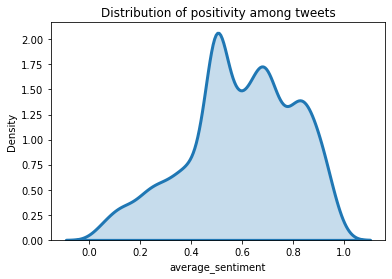

In [ ]:
import seaborn as sns
positivity = tracker["average_sentiment"]
def transform_positive(x):
  return (x + 1) / 2

positivity = positivity.apply(transform_positive)
sns.distplot(positivity, hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3}).set_title("Distribution of positivity among tweets")


What we see in terms of distribution appears to be quite standard. Our most common 'positivity' is at around 0.5 - which means relatively neutral sentiment tweets - which should be expected in professional circumstances. Overall, the sentiment appears to look mostly normally distributed (that is bell-shaped) which means that extremely positive or negative tweets tend to be less common than 'neutral' tweets overall. 

There may some confusion regarding this result, especially considering the dominance of positive tweets in our earlier pie chart. However, what we saw earlier seems to be an effect of there being a higher range of 'positive' sentiments than 'neutral' (neutral has compound between -0.05 to 0.05, whereas positive is 0.05 to 1. 0.95 is far more than 0.1). While the peaks for 'neutral' tweets seem to be higher because these sentiments tend to be more dense overall, there are more positive tweets, as the area for higher sentiments in the graph is greater than that at the centre. It also far exceeds that of the lower sentiments of the graph, which aligns with what we saw in the pie chart.

Overall, this was an interesting task where I quickly utilised my general Python programming skills and also developed my data visualisation and data manipulation skills (with Pandas particularly). I have outlined a few things I would like to do if I had more time throughout this notebook, but the general idea is that I would spend more time processing grammar (for example, I saw some emojis come up in some of my results when perhaps this isn't sensible for the final result), considering individual semantics, other cool visualisations/explorations of the data and cleaning up/rigorously testing my code/making some things faster by using Numpy for example instead of traditional Python lists. Lastly, I would also compare multiple sentiment analysis libraries and use a mix of metrics and my own judgement to decide which one seems to be best for the task at hand, and further exploration.